# IMAGINE tour

![Drag Racing](pipeline_diagram.svg)

## Fields

Relevant docs:
* https://imagine-code.readthedocs.io/en/latest/tutorial_fields.html
* https://imagine-code.readthedocs.io/en/latest/components.html#fields
* https://imagine-code.readthedocs.io/en/latest/imagine.fields.html

Now let us try to create our own field. A few relevant imports

In [1]:
import imagine as img
import astropy.units as u
import numpy as np
import cmasher as cmr
import matplotlib.pyplot as plt
import healpy as hp


### Grids
First, let us talk a bit about grids. The following creates a regular cartesian grid

In [2]:
small_grid = img.fields.UniformGrid(box=[[-20*u.kpc, 20*u.kpc], # box x edges
                                         [-20*u.kpc, 20*u.kpc], # box y edges
                                         [-2*u.kpc, 2*u.kpc], # box z edges
                                        ],
                                    resolution=[3,3,4])

large_grid = img.fields.UniformGrid(box=[[-20*u.kpc, 20*u.kpc], # box x edges
                                         [-20*u.kpc, 20*u.kpc], # box y edges
                                         [-2*u.kpc, 2*u.kpc], # box z edges
                                        ],
                                    resolution=[150,150,100])

The cartesian coordinates can be accessed through, e.g.

In [3]:
small_grid.x

<Quantity [[[-20., -20., -20., -20.],
            [-20., -20., -20., -20.],
            [-20., -20., -20., -20.]],

           [[  0.,   0.,   0.,   0.],
            [  0.,   0.,   0.,   0.],
            [  0.,   0.,   0.,   0.]],

           [[ 20.,  20.,  20.,  20.],
            [ 20.,  20.,  20.,  20.],
            [ 20.,  20.,  20.,  20.]]] kpc>

If needed, spherical and cylindrical coordinates are available

In [4]:
small_grid.r_cylindrical

<Quantity [[[28.28427125, 28.28427125, 28.28427125, 28.28427125],
            [20.        , 20.        , 20.        , 20.        ],
            [28.28427125, 28.28427125, 28.28427125, 28.28427125]],

           [[20.        , 20.        , 20.        , 20.        ],
            [ 0.        ,  0.        ,  0.        ,  0.        ],
            [20.        , 20.        , 20.        , 20.        ]],

           [[28.28427125, 28.28427125, 28.28427125, 28.28427125],
            [20.        , 20.        , 20.        , 20.        ],
            [28.28427125, 28.28427125, 28.28427125, 28.28427125]]] kpc>

In [5]:
small_grid.theta

<Quantity [[[1.64138951, 1.59436219, 1.54723046, 1.50020315],
            [1.67046498, 1.60411732, 1.53747533, 1.47112767],
            [1.64138951, 1.59436219, 1.54723046, 1.50020315]],

           [[1.67046498, 1.60411732, 1.53747533, 1.47112767],
            [3.14159265, 3.14159265, 0.        , 0.        ],
            [1.67046498, 1.60411732, 1.53747533, 1.47112767]],

           [[1.64138951, 1.59436219, 1.54723046, 1.50020315],
            [1.67046498, 1.60411732, 1.53747533, 1.47112767],
            [1.64138951, 1.59436219, 1.54723046, 1.50020315]]] rad>

### Creating a simple Field
Now, let us create our own field. 

In [6]:
from imagine.fields.base_fields import ThermalElectronDensityField

class ExponentialThermalElectrons(ThermalElectronDensityField):
    """Example: thermal electron density of an (double) exponential disc"""
    
    NAME = 'exponential_disc_thermal_electrons'
    
    @property
    def field_checklist(self):
        return {'central_density' : None, 
                'scale_radius' : None,
                'scale_height' : None}
    
    def compute_field(self, seed):
        R = self.grid.r_cylindrical
        z = self.grid.z
        Re = self.parameters['scale_radius']
        he = self.parameters['scale_height']
        n0 = self.parameters['central_density']
        
        return n0*np.exp(-R/Re)*np.exp(-np.abs(z/he))

We can make an instance of it

In [7]:
te_field = ExponentialThermalElectrons(grid=large_grid, 
                                       parameters={'scale_radius': 5*u.kpc,
                                                   'scale_height': 200*u.pc,
                                                   'central_density': 1*u.cm**-3})

The data this `Field` generates can be obtained in the following way

In [8]:
te_data_array = te_field.get_data()

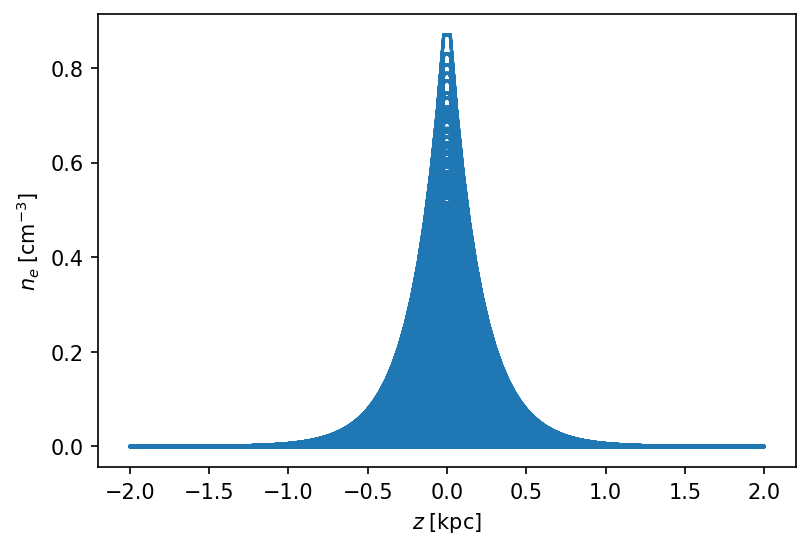

In [9]:
plt.figure(dpi=150)
plt.plot(large_grid.z.ravel(), 
         te_data_array.ravel())
plt.xlabel(r'$z\;[\rm kpc]$'); plt.ylabel(r'$n_e\;[\rm cm^{-3}]$');

## Datasets and Measurements


Relevant docs:
* https://imagine-code.readthedocs.io/en/latest/tutorial_datasets.html
* https://imagine-code.readthedocs.io/en/latest/components.html#datasets
* https://imagine-code.readthedocs.io/en/latest/imagine.observables.html#imagine-observables-package

Say we have some Faraday depth maps data sitting on our disk somewhere. How could we use this within IMAGINE?

/home/lfsr/.local/lib/python3.7/site-packages/healpy-1.12.8-py3.7-linux-x86_64.egg/healpy/projaxes.py:989: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/lfsr/.local/lib/python3.7/site-packages/healpy-1.12.8-py3.7-linux-x86_64.egg/healpy/projaxes.py:959: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


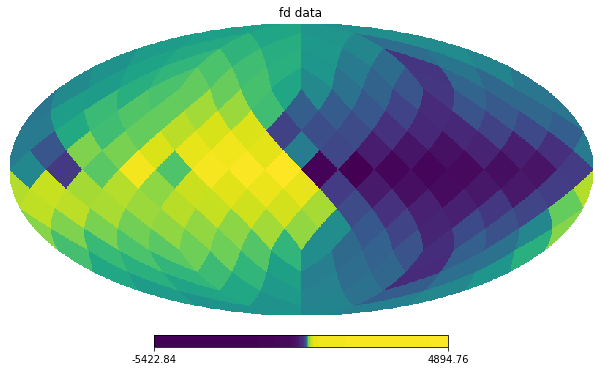

In [10]:
fd_data = np.load('rm_example.npy')
hp.mollview(fd_data, norm='hist', title='fd data')

If we want to add this to IMAGINE, we can use one of the `Dataset` subclasses

In [11]:
fd_dset = img.observables.FaradayDepthHEALPixDataset(fd_data*u.rad/u.m**2, 
                                                     error=0.01)

This assumes that the error is the same on every pixel and that the covariance matrix is diagonal. A keyword argument `cov` may be used to supply a covariance matrix, if available.

Multiple datasets can be loaded on a Measurements and Covariances dictionaries. We illustrate with the dataset above.

In [12]:
# Initializes
measurements = img.observables.Measurements()
covariances = img.observables.Covariances()
# Appends the dataset
measurements.append(dataset=fd_dset)
covariances.append(dataset=fd_dset)

We can check what is inside these, by inspecting their keys:

In [13]:
measurements.keys()

dict_keys([('fd', 'nan', '4', 'nan')])

## Using our field with Hammurabi Simulator

Relevant docs:
* https://imagine-code.readthedocs.io/en/latest/tutorial_hammurabi.html
* https://imagine-code.readthedocs.io/en/latest/imagine.simulators.html#imagine-simulators-package
* https://imagine-code.readthedocs.io/en/latest/components.html#simulators


Lets say we would like to use the field we created with a Simulator. More specifically, say we want to use with Hammurabi.  

We will now quickly illustrate this, but there is one necessary digression.


### Dummy fields

These are a special type of Field for sending information to a Simulator which displays builtin Fields.

In [14]:
from imagine.fields.hamx import BregLSA, CREAna

## Set up the BregLSA field with the parameters you want:
paramlist = {'b0': 6.0, 'psi0': 27.9, 'psi1': 1.3, 'chi0': 24.6}
breg_wmap = BregLSA(parameters=paramlist)

## Set up the analytic CR model CREAna 
paramlist_cre = {'alpha': 3.0, 'beta': 0.0, 'theta': 0.0,
                 'r0': 5.6, 'z0': 1.2,
                 'E0': 20.5,
                 'j0': 0.03}
cre_ana = CREAna(parameters=paramlist_cre)

As these are not evaluated, their "data" is actually just their parameter values (supplemented by a random seed)

In [15]:
breg_wmap.get_data()

{'b0': 6.0, 'psi0': 27.9, 'psi1': 1.3, 'chi0': 24.6, 'random_seed': 470272697}

### Using a Simulator (Hammurabi)

To inialize a simulator, we have to provide it with a `Measurements` object. 
The Simulator inspect the `Measurements` and adjust its settings to produce simulated data (i.e. a `Simulations` object) in
the exact same format.

We shall use the `measurments` object that we created a little earlier.

In [16]:
simulator = img.simulators.Hammurabi(measurements=measurements)

observable {}
|-->  faraday {'cue': '1', 'nside': '4'}


Now that the simulator is initialized, we can use it to run Hammurabi on our `te_field`. We will use the dummy field to instruct Hammurabi to rely on its internal magnetic field. 

In [17]:
simulations = simulator(field_list=[te_field, breg_wmap, cre_ana])

And now we get a populated `Simulations` object

In [18]:
type(simulations)

imagine.observables.observable_dict.Simulations

In [19]:
simulations.keys()

dict_keys([('fd', 'nan', '4', 'nan')])

Let us now extract the simulated data from this and plot it, comparing with the "measured" data loaded from the disk

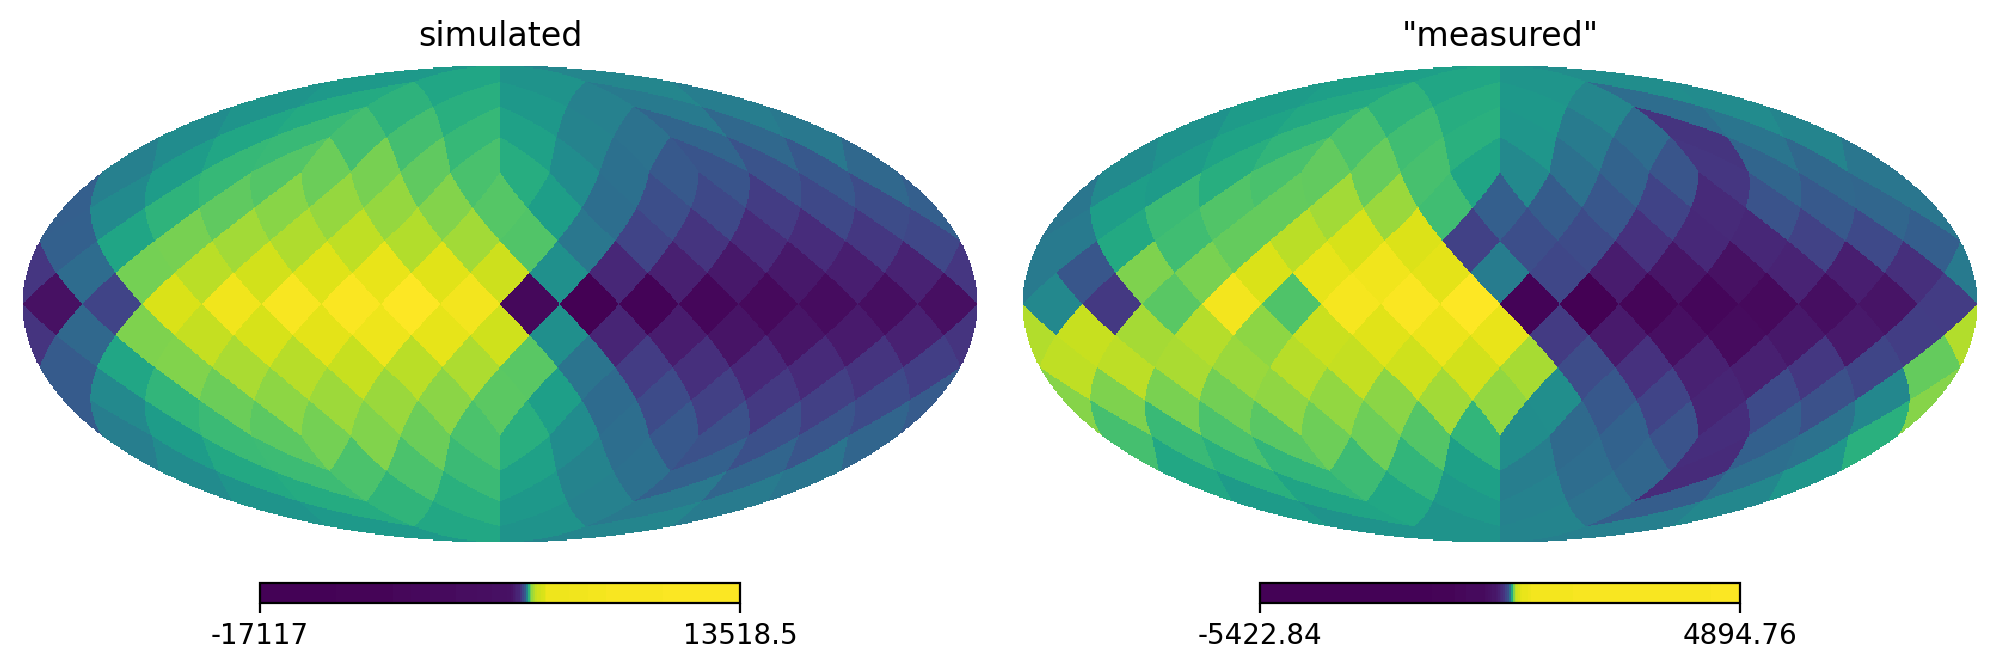

In [20]:
simulated_map = simulations[('fd', 'nan', '4', 'nan')].global_data[0]
fig = plt.figure(figsize=(10.0, 4.0),dpi=200)
hp.mollview(simulated_map, norm='hist', title='simulated', sub=(1,2,1))
hp.mollview(fd_data, norm='hist', title='"measured"', sub=(1,2,2))

## Field factories and priors

Relevant docs:
* https://imagine-code.readthedocs.io/en/latest/tutorial_fields.html
* https://imagine-code.readthedocs.io/en/latest/components.html#field-factory
* https://imagine-code.readthedocs.io/en/latest/tutorial_priors.html
* https://imagine-code.readthedocs.io/en/latest/components.html#priors

We would like to explore the parameter space of the field we added. Before doing this we need to setup a FieldFactory. 

In [21]:
from imagine.fields import FieldFactory
from imagine.priors import FlatPrior, GaussianPrior

class ExponentialThermalElectronsFactory(FieldFactory):
    # Class attributes
    FIELD_CLASS = ExponentialThermalElectrons
    DEFAULT_PARAMETERS = {'central_density': 1*u.cm**-3,
                          'scale_radius': 3.0*u.kpc,
                          'scale_height': 0.5*u.kpc}
    PRIORS = {'central_density': FlatPrior(interval=[0, 10]*u.cm**-3),
              'scale_radius': FlatPrior(interval=[1, 10]*u.kpc),
              'scale_height': FlatPrior(interval=[0.01, 5]*u.kpc)}

In [22]:
te_factory = ExponentialThermalElectronsFactory(grid=large_grid)

### Priors

We can use FlatPriors as above but also GaussianPriors

In [23]:
prior = te_factory.priors['central_density']  # this allows us to inspect the priors of a Factory
priorGaussian = GaussianPrior(mu=1*u.cm**-3, sigma=0.5*u.cm**-3,
                              interval=[0, 10]*u.cm**-3)

We can have a look at its PDF in the following way

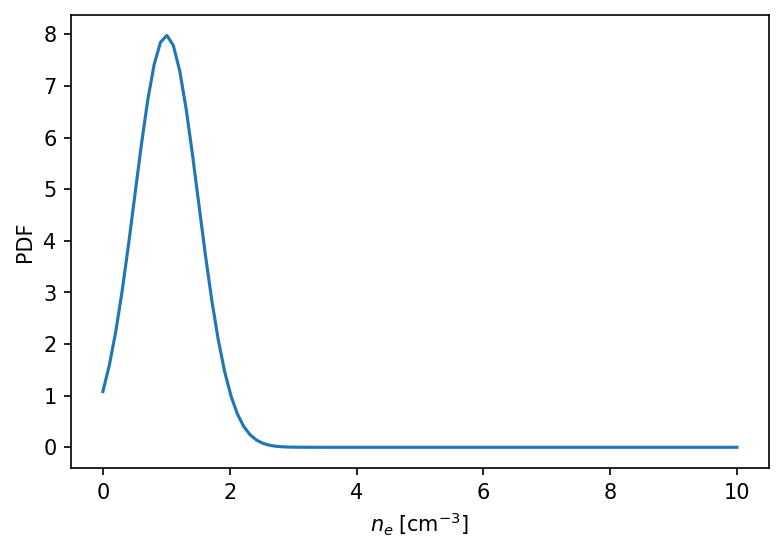

In [24]:
ne = np.linspace(0,10,100)*u.cm**-3
plt.figure(dpi=150)
plt.plot(ne, priorGaussian.pdf_unscaled(ne))
plt.xlabel(r'$n_e\;[\rm cm^{-3}]$'); plt.ylabel('PDF');

### More on the Field Factory

During a Pipeline run parameters can be active (meaning they are varied) or inactive (i.e. fixed to the default value).

In [25]:
te_factory.active_parameters = ['central_density','scale_height']

In [26]:
# This is done internally by the Pipeline
te_generated_field = te_factory(variables={'central_density': 0.4})
te_generated_field.parameters

{'central_density': <Quantity 4. 1 / cm3>,
 'scale_radius': <Quantity 3. kpc>,
 'scale_height': <Quantity 0.5 kpc>}

## Likelihood

Our final missing piece is a `Likelihood` object, which instructs how to compute the likelihood given a observational dataset and an ensemble of model realisations

In [27]:
likelihood = img.likelihoods.SimpleLikelihood(measurements, covariances)

## The Pipeline 

We will first import the Field Factories associated with the Dummy fields and assemble a *fields list*

In [28]:
from imagine.fields.hamx import BregLSAFactory, CREAnaFactory

## WMAP B-field, vary only b0 and psi0
breg_factory = BregLSAFactory()
## Fixed CR model
cre_factory = CREAnaFactory()

# Final Field factory list
factory_list = [te_factory, breg_factory, cre_factory]

The pipeline wraps around one specific nested sampling sampler. For this we will use the well-known MultiNest

In [29]:
pipeline = img.pipelines.MultinestPipeline(simulator=simulator,
                                           factory_list=factory_list, 
                                           likelihood=likelihood, 
                                           ensemble_size=1)
pipeline.sampling_controllers = {'n_live_points': 500}

And now all we have to do is running the pipeline!

In [ ]:
results = pipeline()